## Generate music with Variational AutoEncoder
![iame_intro](https://i.ytimg.com/vi/WI1xExDWVF0/maxresdefault.jpg)

## Introduction
This work is inspired by the research paper [Jukebox: A Generative Model for Music](https://cdn.openai.com/papers/jukebox.pdf). In this notebook, I have developed a generative model that could generate music from a variational autoencoder trained with a category of music. I have selected the jazz and classical music categories. The entire model is implemented in TensorFlow and used Librosa for audio processing. The input sampling rate is 3000 for processing the audio file into a readable array.

## What is Variational AutoEncoder?
 VAE is an autoencoder whose encodings distribution is regularised during the training in order to ensure that its latent space has good properties allowing us to generate some new data. A variational autoencoder (VAE) provides a probabilistic manner for describing an observation in latent space.
![VAE](https://miro.medium.com/max/3080/1*82EghOQR2Z5uuwUjFiVV2A.png) 

Source -  [The Intuition Behind Variational Autoencoders](https://medium.com/@realityenginesai/understanding-variational-autoencoders-and-their-applications-81a4f99efc0d), [Variational autoencoders.](https://www.jeremyjordan.me/variational-autoencoders/)

In [42]:
#!/opt/conda/bin/python3.7 -m pip install --upgrade pip
#!pip install tensorflow-addons
#!pip install --upgrade --ignore-installed tensorflow
#!pip install -q imageio
!pip install -q git+https://github.com/tensorflow/docs


librosa: Python module for audio and music processing

In [2]:
#!pip install librosa

In [2]:
import librosa

import numpy as np
import pandas as pd
import os

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers 

import matplotlib.pyplot as plt
from IPython import display
from IPython.display import clear_output

import glob
import imageio
import time
import IPython.display as ipd

AUTOTUNE = tf.data.experimental.AUTOTUNE

C:\Users\rayja\anaconda3\envs\python3813\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [5]:
seed=123
tf.compat.v1.set_random_seed(seed)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [50]:
train_size = 0.8 
BATCH_SIZE = 8
test_size =  0.2
epochs = 100
# set the dimensionality of the latent space to a plane for visualization later
latent_dim = 32
num_examples_to_generate = 2

BASE_PATH = './GTZAN_Dataset_Music_Genre_Classification/Data/genres_original'

## Data preprocessing

In [152]:
def DatasetLoader(class_):
    music_list = np.array(sorted(os.listdir(BASE_PATH+'/'+class_)))
    len_music = music_list.shape[0]
    
    print('total audio: :', len_music)
    
    # devide to train and test sets
    
    train_music = list(music_list[:int(len_music * train_size)]) 
    test_music = list(music_list[int(len_music * train_size):]) 
    
    TrainkSet = [(BASE_PATH)+'/'+class_+'/%s'%(x) for x in train_music]
    TestSet = [(BASE_PATH)+'/'+class_+'/%s'%(x) for x in test_music]

    return TrainkSet, TestSet

In [153]:
def load(file_):
    data_, sampling_rate = librosa.load(file_,sr=3000, offset=0.0, duration=30)
    #print('data shape: ',data_.shape)
    
    data_ = data_.reshape(1,90001)
    return data_
map_data = lambda filename: tf.compat.v1.py_func(load, [filename], [tf.float32])

In [154]:
TrackSet_1, TrackSet_2 = DatasetLoader('jazz')
# train and test

total audio: : 100


In [155]:
print('train length: ', len(TrackSet_1))
print('test length: ', len(TrackSet_2))

train length:  80
test length:  20


## sample original music

In [156]:
sample = TrackSet_1[0]
sample_, sampling_rate = librosa.load(sample,sr=3000, offset=0.0, duration=30)
ipd.Audio(sample_,rate=3000)

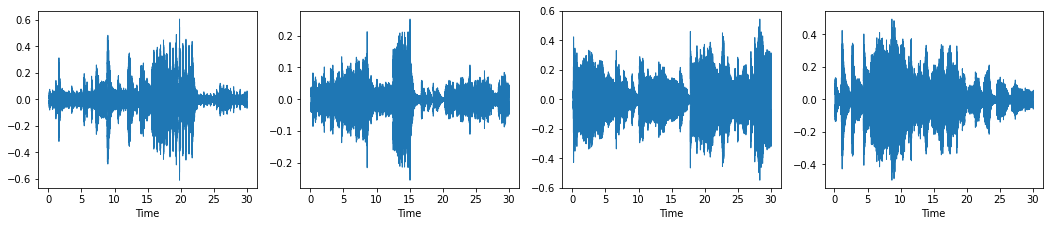

In [157]:
import librosa.display
plt.figure(figsize=(18,15))
for i in range(4):
    plt.subplot(4, 4, i + 1)
    j = load(TrackSet_1[i])
    librosa.display.waveshow(j[0], sr=3000)
    

In [158]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((TrackSet_1))
    .map(map_data, num_parallel_calls=AUTOTUNE)
    .shuffle(3)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((TrackSet_2))
    .map(map_data, num_parallel_calls=AUTOTUNE)
    .shuffle(3)
    .batch(BATCH_SIZE)
)

## VAE

## Encoder network
This defines the approximate posterior distribution *q(z|x)*, which takes as input an observation and outputs a set of parameters for specifying the conditional distribution of the latent representation *z*. In this example, we simply model the distribution as a diagonal Gaussian, and the network outputs the mean and log-variance parameters of a factorized Gaussian. We output log-variance instead of the variance directly for numerical stability.
## Decoder network
This defines the conditional distribution of the observation *p(x|z)*, which takes a latent sample *z* as input and outputs the parameters for a conditional distribution of the observation. We model the latent distribution prior *p(z)* as a unit Gaussian.
## Reparameterization
To generate a sample *z* for the decoder during training, we can sample from the latent distribution defined by the parameters outputted by the encoder, given an input observation *x*. However, this sampling operation creates a bottleneck because backpropagation cannot flow through a random node.

To address this, we use a reparameterization trick. In our example, we approximate *z* using the decoder parameters and another parameter *ϵ* as follows:

z = μ + σ.ϵ

Source: [Tensorflow](https://www.tensorflow.org/tutorials/generative/cvae)

## Network architecture

In [183]:
class VAE(tf.keras.Model):
    """ variational autoencoder."""

    def __init__(self, latent_dim, shape=(1,90001)):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        # Simple FCN
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer((shape[0],shape[1],)),
                layers.Reshape(target_shape=(shape[1], )),
                layers.Dense(512, activation='relu'),
                layers.Dense(256, activation='relu'),
                layers.Dense(128, activation='relu'),
                layers.Dense(latent_dim+latent_dim)

            ]
        )
        # Decoder
        # Simple FCN
        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer((latent_dim,)),
                
                layers.Dense(128, activation='relu'),
                layers.Dense(256, activation='relu'),
                layers.Dense(512, activation='relu'),
                layers.Dense(shape[-1]),
                layers.Reshape(target_shape=(shape[0],shape[1])),
            ]
        )
    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(200, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
    @tf.function
    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar
    @tf.function
    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
    @tf.function
    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [184]:
optimizer = tf.keras.optimizers.Adam(0.0003,beta_1=0.9, beta_2=0.999,epsilon=1e-08)

In [185]:
@tf.function
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
         -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
          axis=raxis)

In [186]:
@tf.function
def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

## Loss Optimization
Here we have optimized two lossess, the **KL loss** and **reconstruction loss**.<br>

## KL Loss

The KL divergence tells us how well the probability distribution Q approximates the probability distribution P by calculating the cross-entropy minus the entropy. Intuitively, you can think of that as the statistical measure of how one distribution differs from another.
In VAE, let X be the data we want to model, z be latent variable, P(X) be the probability distribution of data, P(z) be the probability distribution of the latent variable and P(X|z) be the distribution of generating data given latent variable.

In the case of variational autoencoders, our objective is to infer P(z)
from P(z|X). P(z|X) is the probability distribution that projects our data into latent space. But since we do not have the distribution P(z|X), we estimate it using its simpler estimation Q.

Now while training our VAE, the encoder should try to learn the simpler distribution Q(z|X)
such that it is as close as possible to the actual distribution P(z|X). This is where we use KL divergence as a measure of a difference between two probability distributions. The VAE objective function thus includes this KL divergence term that needs to be minimized.

*DKL[Q(z|X)||P(z|X)] = E[ logQ(z|X) − logP(z|X) ]*

## Reconstruction loss
As the name suggest, it measures the reconstruction of original input x. This network can be trained by minimizing the reconstruction error, which measures the differences between our original input and the consequent reconstruction.

In [187]:
@tf.function
def train_step(model, x, optimizer):
    
    """Executes one training step and returns the loss.

       This function computes the loss and gradients, and uses the latter to
       update the model's parameters.
     """
    with tf.GradientTape() as tape:
            mean, logvar = model.encode(x)
            z = model.reparameterize(mean, logvar)
            x_logit = model.decode(z)
            cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
            logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2])
            logpz = log_normal_pdf(z, 0., 0.)
            logqz_x = log_normal_pdf(z, mean, logvar)
            loss_KL = -tf.reduce_mean(logpx_z + logpz - logqz_x)
            reconstruction_loss = tf.reduce_mean(
                     tf.keras.losses.binary_crossentropy(x, x_logit)
                 )
            total_loss = reconstruction_loss+ loss_KL
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [188]:
# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = VAE(latent_dim)

In [189]:
import librosa.display

def generate_and_save_images(model, epoch, test_sample, save):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    fig = plt.figure(figsize=(18, 15))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        wave = np.asarray(predictions[i])
        librosa.display.waveshow(wave[0], sr=3000)

    # tight_layout minimizes the overlap between 2 sub-plots
    plt.savefig('{}_{:04d}.png'.format(save, epoch))
    plt.savefig('{}_{:04d}.png'.format(save, epoch))
    plt.show()

In [190]:
# Pick a sample of the test set for generating output images
assert BATCH_SIZE >= num_examples_to_generate
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0]

## Training the model

In [191]:
elbo_loss_train = []
elbo_loss_test = []

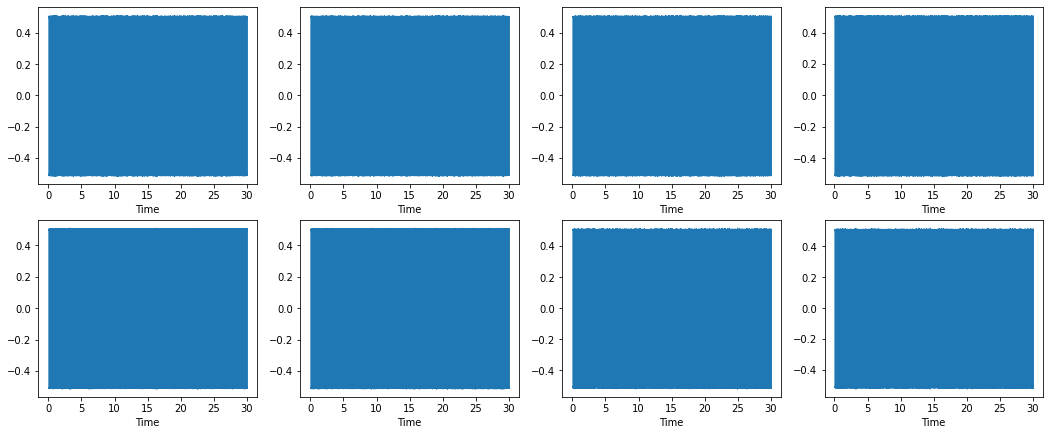

In [192]:
generate_and_save_images(model, 0, test_sample, 'jazz')
def train(train_dataset, test_dataset, model, save):
    for epoch in range(1, epochs + 1):
        start_time = time.time()
        for train_x in train_dataset:
            train_x = np.asarray(train_x)[0]
            train_step(model, train_x, optimizer)
        end_time = time.time()

        loss = tf.keras.metrics.Mean()
        
        tr_elbo =  -loss.result()
        elbo_loss_train.append(tr_elbo)
        
        # validate
        for test_x in test_dataset:
            test_x = np.asarray(test_x)[0]
            loss(compute_loss(model, test_x))
        
        display.clear_output(wait=False)
        elbo = -loss.result()
        print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'.format(epoch, 
                                                                                       elbo, 
                                                                                       end_time - start_time
                                                                                      ))
        generate_and_save_images(model,
                                 epoch, 
                                 test_sample,
                                 save)
        elbo_loss_test.append(elbo)
    

Epoch: 100, Test set ELBO: -279149.4375, time elapse for current epoch: 8.978200197219849


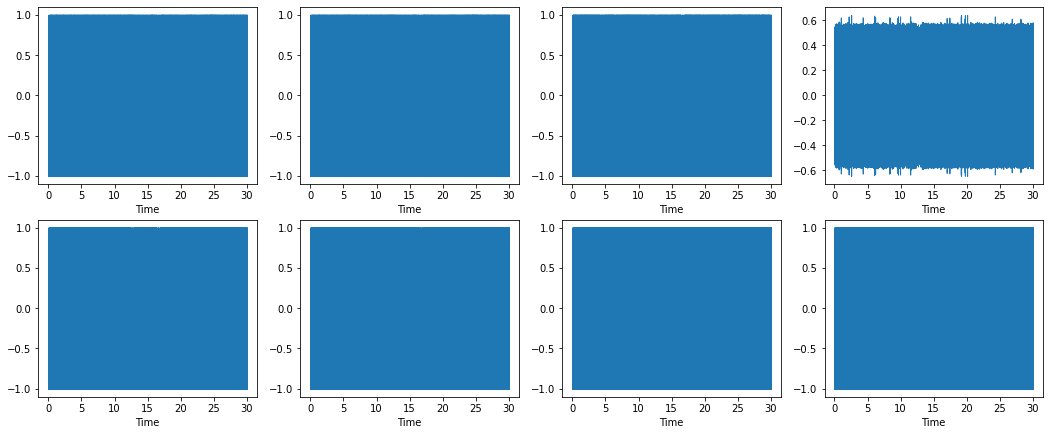

In [194]:
train(train_dataset, test_dataset, model, 'jazz')

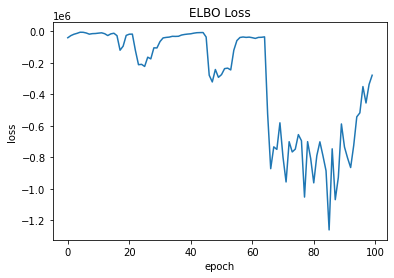

In [212]:
plt.plot(elbo_loss_test)
plt.title('ELBO Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [195]:
anim_file_1 = 'jazz_cvae.gif'

with imageio.get_writer(anim_file_1, mode='I') as writer:
    filenames = glob.glob('jazz*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

C:\Users\rayja\AppData\Local\Temp\ipykernel_16944\320702405.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
C:\Users\rayja\AppData\Local\Temp\ipykernel_16944\320702405.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


## Visualization


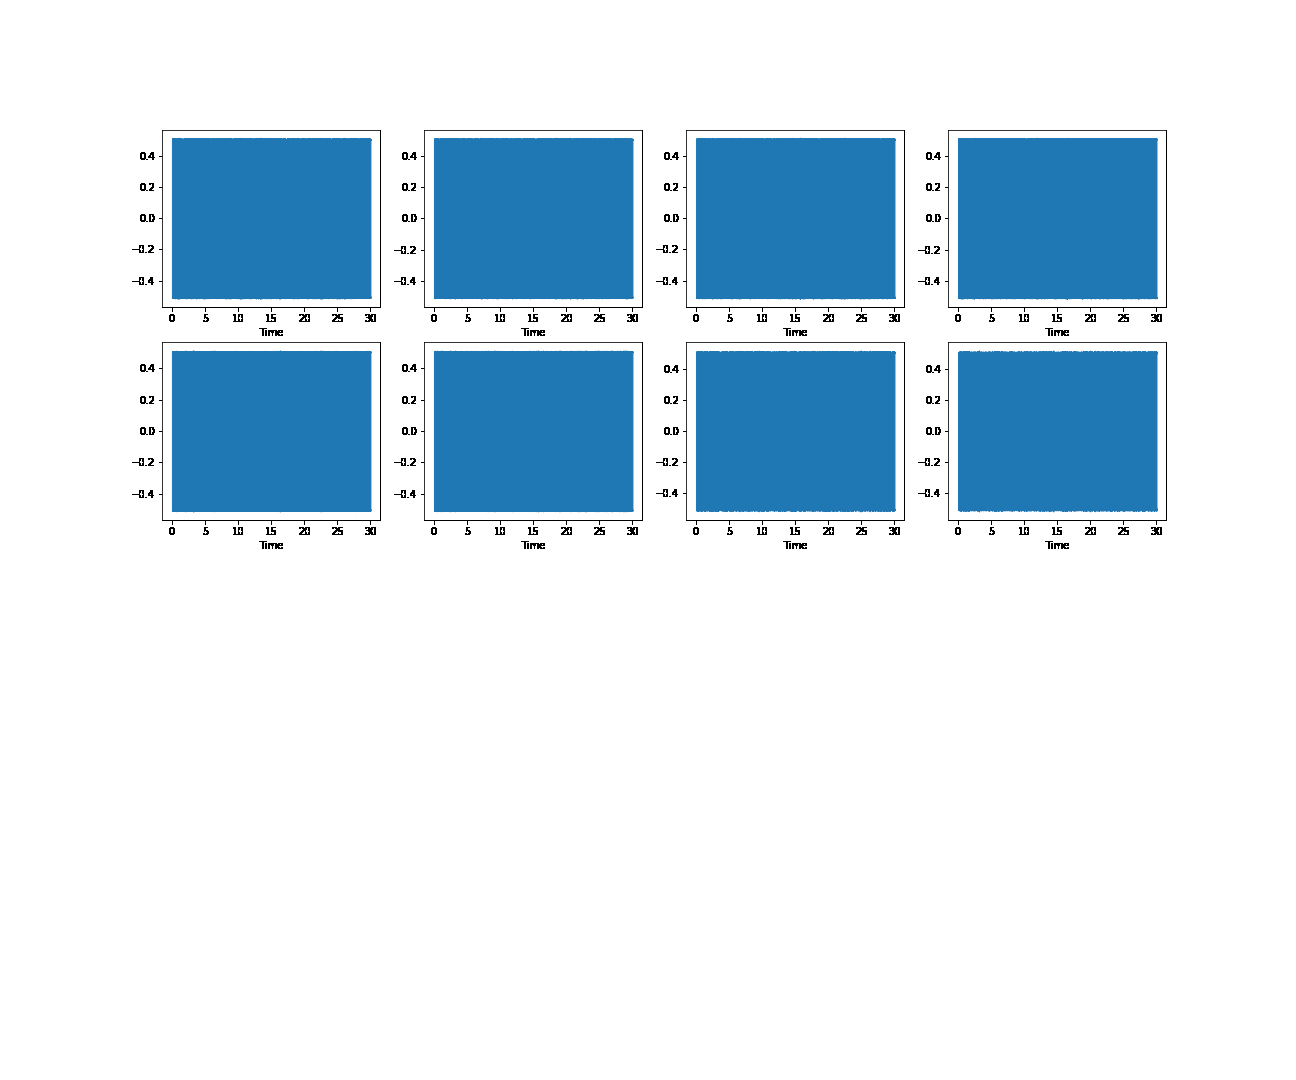

In [196]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file_1)

## Generated Music - Jazz
Let us listen to the music generated by our model, trained only with jazz music.

In [197]:
def inference(test_dataset, model):  
    save_music = []
    for test in test_dataset:
        mean, logvar = model.encode(test)
        z = model.reparameterize(mean, logvar)
        predictions = model.sample(z)
        for pred in predictions:
            wave = np.asarray(pred)
            save_music.append(wave)
    return save_music

saved_musics = inference(test_dataset, model)

In [200]:
len(saved_musics)

20

In [201]:
for music in saved_musics:
    music = music[0]
    ipd.Audio(music,rate=3000)

In [198]:
music1=saved_musics[0][0]
ipd.Audio(music1,rate=3000)

In [202]:
music2=saved_musics[1][0]
ipd.Audio(music2,rate=3000)

In [ ]:
music3=saved_musics[5][0]
ipd.Audio(music3,rate=3000)

In [ ]:
music4=saved_musics[10][0]
ipd.Audio(music4,rate=3000)

In [ ]:
music5=saved_musics[8][0]
ipd.Audio(music5,rate=3000)

In [ ]:
music6=saved_musics[7][0]
ipd.Audio(music6,rate=3000)

# GAN


# Discriminator

In [250]:
def define_discriminator(shape=(1,90001)):
    
    model = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer((shape[0],shape[1],)),
                layers.Reshape(target_shape=(shape[1], )),
                layers.Dense(512, activation='relu'),
                layers.Dense(256, activation='relu'),
                layers.Dense(128, activation='relu'),
                layers.Dense(1, activation="sigmoid")

            ]
        )
    
    # compile model
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model



# Generator

In [251]:
def define_generator(latent_dim, shape=(1,90001)):
    model = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer((latent_dim,)),
                
                layers.Dense(128, activation='relu'),
                layers.Dense(256, activation='relu'),
                layers.Dense(512, activation='relu'),
                layers.Dense(shape[-1], activation='tanh'),
                layers.Reshape(target_shape=(shape[0], shape[1])),
            ]
        )
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

# Combine into GAN

In [252]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = tf.keras.models.Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss="binary_crossentropy", optimizer="adam")
    return model

In [253]:
def generate_real_samples(x_batch, batch_size):
    
    y_batch = np.ones((batch_size, 1))
    return x_batch, y_batch

In [254]:
def generate_latent_points(latent_dim, batch_size):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim * batch_size)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(batch_size, latent_dim)
    return x_input

In [255]:
def generate_fake_samples(generator, latent_dim, batch_size):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, batch_size)
    
    # fake inputs from generator
    x_batch = generator.predict(x_input)
    
    
    y = np.zeros((batch_size, 1))
    return x_batch, y

In [256]:
# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, X,  batch_size=100):
    # prepare real samples
    x_real, y_real = generate_real_samples(X,  batch_size)
    # evaluate discriminator on real examples
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(generator, latent_dim,  batch_size)
    # evaluate discriminator on fake examples
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print(epoch, acc_real, acc_fake)

In [275]:
gen_loss = []
dis_loss = []

# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, train_dataset, n_epochs=100, n_batch=8):
    # determine half the size of one batch, for updating the discriminator
    #half_batch = int(n_batch / 2)
    
    # manually enumerate epochs
    for i in range(n_epochs):
        print('epoch: ',i)
        # prepare real samples
        for ii,train_x in enumerate(train_dataset):
            
            train_x = np.array(train_x[0])
            
            x_real, y_real = generate_real_samples(train_x, n_batch)
            
            # prepare fake examples
            x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_batch)
            #print(x_real.shape)
            #print(x_fake.shape)
            
            # concatenate
            x = np.concatenate((x_real, x_fake))  
            y = np.concatenate((y_real, y_fake))  
            
            # update discriminator
            d_loss =  d_model.train_on_batch(x,y)
            
            # prepare points in latent space as input for the generator
            x_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(x_gan, y_gan)
            
            gen_loss.append(g_loss)
            dis_loss.append(d_loss[0])
            
            print(f'Iteration: {epochs * n_batch + ii} \t Discriminator Loss/Acc: {d_loss} \t\t Generator Loss: {g_loss}')
            

In [276]:
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)

In [277]:
# train model
train(generator, discriminator, gan_model, latent_dim, train_dataset)

epoch:  0
Iteration: 800 	 Discriminator Loss/Acc: [0.6984154582023621, 0.5] 		 Generator Loss: 1.2636620998382568
Iteration: 801 	 Discriminator Loss/Acc: [1.4709832668304443, 0.375] 		 Generator Loss: 0.43897101283073425
Iteration: 802 	 Discriminator Loss/Acc: [1.2157297134399414, 0.5] 		 Generator Loss: 1.031659722328186
Iteration: 803 	 Discriminator Loss/Acc: [0.6073483228683472, 1.0] 		 Generator Loss: 2.6953744888305664
Iteration: 804 	 Discriminator Loss/Acc: [0.3511120676994324, 1.0] 		 Generator Loss: 4.551571846008301
Iteration: 805 	 Discriminator Loss/Acc: [0.2888951599597931, 1.0] 		 Generator Loss: 4.358055114746094
Iteration: 806 	 Discriminator Loss/Acc: [0.12020931392908096, 1.0] 		 Generator Loss: 4.712690353393555
Iteration: 807 	 Discriminator Loss/Acc: [0.11760924756526947, 1.0] 		 Generator Loss: 3.8763301372528076
Iteration: 808 	 Discriminator Loss/Acc: [0.1622154414653778, 1.0] 		 Generator Loss: 1.8967446088790894
Iteration: 809 	 Discriminator Loss/Acc: [0.

Iteration: 807 	 Discriminator Loss/Acc: [0.02982380799949169, 1.0] 		 Generator Loss: 12.210573196411133
Iteration: 808 	 Discriminator Loss/Acc: [0.0036530420184135437, 1.0] 		 Generator Loss: 15.928099632263184
Iteration: 809 	 Discriminator Loss/Acc: [7.815819117240608e-05, 1.0] 		 Generator Loss: 16.38384246826172
epoch:  8
Iteration: 800 	 Discriminator Loss/Acc: [0.06413641571998596, 0.9375] 		 Generator Loss: 17.218517303466797
Iteration: 801 	 Discriminator Loss/Acc: [0.8706298470497131, 0.875] 		 Generator Loss: 13.990310668945312
Iteration: 802 	 Discriminator Loss/Acc: [0.15124715864658356, 0.9375] 		 Generator Loss: 9.689786911010742
Iteration: 803 	 Discriminator Loss/Acc: [0.6434502601623535, 0.75] 		 Generator Loss: 9.885311126708984
Iteration: 804 	 Discriminator Loss/Acc: [0.01078166626393795, 1.0] 		 Generator Loss: 11.982017517089844
Iteration: 805 	 Discriminator Loss/Acc: [0.15592430531978607, 0.9375] 		 Generator Loss: 11.345124244689941
Iteration: 806 	 Discrimi

Iteration: 803 	 Discriminator Loss/Acc: [0.08391949534416199, 1.0] 		 Generator Loss: 2.9370946884155273
Iteration: 804 	 Discriminator Loss/Acc: [0.11345702409744263, 1.0] 		 Generator Loss: 3.256592273712158
Iteration: 805 	 Discriminator Loss/Acc: [0.26612162590026855, 0.8125] 		 Generator Loss: 3.2888779640197754
Iteration: 806 	 Discriminator Loss/Acc: [0.13131988048553467, 1.0] 		 Generator Loss: 3.883749008178711
Iteration: 807 	 Discriminator Loss/Acc: [0.06220157444477081, 1.0] 		 Generator Loss: 4.404108047485352
Iteration: 808 	 Discriminator Loss/Acc: [0.11658528447151184, 1.0] 		 Generator Loss: 3.7638955116271973
Iteration: 809 	 Discriminator Loss/Acc: [1.0973318815231323, 0.5] 		 Generator Loss: 3.7199034690856934
epoch:  16
Iteration: 800 	 Discriminator Loss/Acc: [1.7091150283813477, 0.5] 		 Generator Loss: 3.0794286727905273
Iteration: 801 	 Discriminator Loss/Acc: [1.6877667903900146, 0.5] 		 Generator Loss: 1.6523959636688232
Iteration: 802 	 Discriminator Loss/Ac

Iteration: 800 	 Discriminator Loss/Acc: [4.015703201293945, 0.75] 		 Generator Loss: 5.196211814880371
Iteration: 801 	 Discriminator Loss/Acc: [2.256859540939331, 0.5] 		 Generator Loss: 6.857260704040527
Iteration: 802 	 Discriminator Loss/Acc: [0.24341318011283875, 0.9375] 		 Generator Loss: 7.84310245513916
Iteration: 803 	 Discriminator Loss/Acc: [0.037934958934783936, 1.0] 		 Generator Loss: 8.502643585205078
Iteration: 804 	 Discriminator Loss/Acc: [0.0015681046061217785, 1.0] 		 Generator Loss: 10.263433456420898
Iteration: 805 	 Discriminator Loss/Acc: [0.06571057438850403, 0.9375] 		 Generator Loss: 14.222527503967285
Iteration: 806 	 Discriminator Loss/Acc: [0.004383889492601156, 1.0] 		 Generator Loss: 11.385476112365723
Iteration: 807 	 Discriminator Loss/Acc: [0.2028278261423111, 0.9375] 		 Generator Loss: 9.024158477783203
Iteration: 808 	 Discriminator Loss/Acc: [0.0018441426800563931, 1.0] 		 Generator Loss: 8.403867721557617
Iteration: 809 	 Discriminator Loss/Acc: [

Iteration: 807 	 Discriminator Loss/Acc: [0.028719738125801086, 1.0] 		 Generator Loss: 2.9034810066223145
Iteration: 808 	 Discriminator Loss/Acc: [0.036666471511125565, 1.0] 		 Generator Loss: 2.6657886505126953
Iteration: 809 	 Discriminator Loss/Acc: [0.044232022017240524, 1.0] 		 Generator Loss: 2.3462791442871094
epoch:  31
Iteration: 800 	 Discriminator Loss/Acc: [0.05168522149324417, 1.0] 		 Generator Loss: 2.4026241302490234
Iteration: 801 	 Discriminator Loss/Acc: [0.0746488869190216, 1.0] 		 Generator Loss: 2.3146800994873047
Iteration: 802 	 Discriminator Loss/Acc: [0.10196474194526672, 1.0] 		 Generator Loss: 2.000739574432373
Iteration: 803 	 Discriminator Loss/Acc: [0.1688818633556366, 0.9375] 		 Generator Loss: 1.785107970237732
Iteration: 804 	 Discriminator Loss/Acc: [0.18838997185230255, 0.9375] 		 Generator Loss: 1.720301866531372
Iteration: 805 	 Discriminator Loss/Acc: [0.16997161507606506, 0.9375] 		 Generator Loss: 1.6225183010101318
Iteration: 806 	 Discriminat

Iteration: 804 	 Discriminator Loss/Acc: [0.0008205220801755786, 1.0] 		 Generator Loss: 11.916709899902344
Iteration: 805 	 Discriminator Loss/Acc: [0.001461308216676116, 1.0] 		 Generator Loss: 9.643872261047363
Iteration: 806 	 Discriminator Loss/Acc: [0.005260049365460873, 1.0] 		 Generator Loss: 5.97665548324585
Iteration: 807 	 Discriminator Loss/Acc: [0.016750143840909004, 1.0] 		 Generator Loss: 4.558027267456055
Iteration: 808 	 Discriminator Loss/Acc: [2.1394379138946533, 0.875] 		 Generator Loss: 2.5277864933013916
Iteration: 809 	 Discriminator Loss/Acc: [0.1340080201625824, 1.0] 		 Generator Loss: 2.063153028488159
epoch:  39
Iteration: 800 	 Discriminator Loss/Acc: [0.1149473786354065, 1.0] 		 Generator Loss: 1.7450498342514038
Iteration: 801 	 Discriminator Loss/Acc: [0.2547903060913086, 0.8125] 		 Generator Loss: 1.9672110080718994
Iteration: 802 	 Discriminator Loss/Acc: [0.14094817638397217, 1.0] 		 Generator Loss: 2.5593440532684326
Iteration: 803 	 Discriminator Los

Iteration: 801 	 Discriminator Loss/Acc: [0.08436432480812073, 1.0] 		 Generator Loss: 2.8741321563720703
Iteration: 802 	 Discriminator Loss/Acc: [0.06678450107574463, 1.0] 		 Generator Loss: 2.220585823059082
Iteration: 803 	 Discriminator Loss/Acc: [0.06828431785106659, 1.0] 		 Generator Loss: 2.2451138496398926
Iteration: 804 	 Discriminator Loss/Acc: [0.11236178874969482, 0.9375] 		 Generator Loss: 2.2453575134277344
Iteration: 805 	 Discriminator Loss/Acc: [0.08135172724723816, 1.0] 		 Generator Loss: 2.154459238052368
Iteration: 806 	 Discriminator Loss/Acc: [0.1865416020154953, 0.875] 		 Generator Loss: 2.1695618629455566
Iteration: 807 	 Discriminator Loss/Acc: [0.9806438684463501, 0.9375] 		 Generator Loss: 2.0997302532196045
Iteration: 808 	 Discriminator Loss/Acc: [0.0823376476764679, 1.0] 		 Generator Loss: 2.2513670921325684
Iteration: 809 	 Discriminator Loss/Acc: [0.12338768690824509, 1.0] 		 Generator Loss: 1.8738114833831787
epoch:  47
Iteration: 800 	 Discriminator L

Iteration: 808 	 Discriminator Loss/Acc: [0.018856726586818695, 1.0] 		 Generator Loss: 4.368224620819092
Iteration: 809 	 Discriminator Loss/Acc: [0.019331369549036026, 1.0] 		 Generator Loss: 4.541577339172363
epoch:  54
Iteration: 800 	 Discriminator Loss/Acc: [0.022016271948814392, 1.0] 		 Generator Loss: 4.149534225463867
Iteration: 801 	 Discriminator Loss/Acc: [0.02107248455286026, 1.0] 		 Generator Loss: 3.836900234222412
Iteration: 802 	 Discriminator Loss/Acc: [0.07997149229049683, 1.0] 		 Generator Loss: 3.828035354614258
Iteration: 803 	 Discriminator Loss/Acc: [0.045416805893182755, 1.0] 		 Generator Loss: 3.7690370082855225
Iteration: 804 	 Discriminator Loss/Acc: [0.0691751092672348, 1.0] 		 Generator Loss: 3.737642288208008
Iteration: 805 	 Discriminator Loss/Acc: [0.09289499372243881, 1.0] 		 Generator Loss: 4.283123970031738
Iteration: 806 	 Discriminator Loss/Acc: [0.11103063821792603, 0.9375] 		 Generator Loss: 4.137418746948242
Iteration: 807 	 Discriminator Loss/A

Iteration: 805 	 Discriminator Loss/Acc: [0.053409505635499954, 1.0] 		 Generator Loss: 3.0073766708374023
Iteration: 806 	 Discriminator Loss/Acc: [0.056929465383291245, 1.0] 		 Generator Loss: 2.933361530303955
Iteration: 807 	 Discriminator Loss/Acc: [0.026715120300650597, 1.0] 		 Generator Loss: 3.528562545776367
Iteration: 808 	 Discriminator Loss/Acc: [0.03859018161892891, 1.0] 		 Generator Loss: 3.811129570007324
Iteration: 809 	 Discriminator Loss/Acc: [0.022089585661888123, 1.0] 		 Generator Loss: 4.156547546386719
epoch:  62
Iteration: 800 	 Discriminator Loss/Acc: [0.04688297212123871, 1.0] 		 Generator Loss: 4.2705512046813965
Iteration: 801 	 Discriminator Loss/Acc: [0.015743058174848557, 1.0] 		 Generator Loss: 4.531578063964844
Iteration: 802 	 Discriminator Loss/Acc: [0.01105046272277832, 1.0] 		 Generator Loss: 4.4626288414001465
Iteration: 803 	 Discriminator Loss/Acc: [0.009595081210136414, 1.0] 		 Generator Loss: 4.339576721191406
Iteration: 804 	 Discriminator Loss

Iteration: 802 	 Discriminator Loss/Acc: [0.25663524866104126, 0.9375] 		 Generator Loss: 1.3660728931427002
Iteration: 803 	 Discriminator Loss/Acc: [0.22168400883674622, 0.9375] 		 Generator Loss: 1.5711568593978882
Iteration: 804 	 Discriminator Loss/Acc: [0.1554444134235382, 1.0] 		 Generator Loss: 1.8102928400039673
Iteration: 805 	 Discriminator Loss/Acc: [0.13366565108299255, 1.0] 		 Generator Loss: 2.128732681274414
Iteration: 806 	 Discriminator Loss/Acc: [0.07846811413764954, 1.0] 		 Generator Loss: 2.3815951347351074
Iteration: 807 	 Discriminator Loss/Acc: [0.05908099561929703, 1.0] 		 Generator Loss: 2.6648921966552734
Iteration: 808 	 Discriminator Loss/Acc: [0.046087607741355896, 1.0] 		 Generator Loss: 2.825004816055298
Iteration: 809 	 Discriminator Loss/Acc: [0.03691969811916351, 1.0] 		 Generator Loss: 3.0233378410339355
epoch:  70
Iteration: 800 	 Discriminator Loss/Acc: [0.03358342871069908, 1.0] 		 Generator Loss: 3.140251874923706
Iteration: 801 	 Discriminator L

Iteration: 809 	 Discriminator Loss/Acc: [0.30646470189094543, 0.8125] 		 Generator Loss: 8.242063522338867
epoch:  77
Iteration: 800 	 Discriminator Loss/Acc: [0.0026212050579488277, 1.0] 		 Generator Loss: 10.08775520324707
Iteration: 801 	 Discriminator Loss/Acc: [0.00035695344558916986, 1.0] 		 Generator Loss: 11.253645896911621
Iteration: 802 	 Discriminator Loss/Acc: [0.0004291447112336755, 1.0] 		 Generator Loss: 10.815380096435547
Iteration: 803 	 Discriminator Loss/Acc: [0.0005022134864702821, 1.0] 		 Generator Loss: 9.619569778442383
Iteration: 804 	 Discriminator Loss/Acc: [0.0010782917961478233, 1.0] 		 Generator Loss: 8.360807418823242
Iteration: 805 	 Discriminator Loss/Acc: [0.0017135671805590391, 1.0] 		 Generator Loss: 5.964676856994629
Iteration: 806 	 Discriminator Loss/Acc: [0.006066336762160063, 1.0] 		 Generator Loss: 5.812572479248047
Iteration: 807 	 Discriminator Loss/Acc: [0.011234702542424202, 1.0] 		 Generator Loss: 5.5257978439331055
Iteration: 808 	 Discri

Iteration: 805 	 Discriminator Loss/Acc: [0.03338410705327988, 1.0] 		 Generator Loss: 2.752190113067627
Iteration: 806 	 Discriminator Loss/Acc: [0.05479811131954193, 1.0] 		 Generator Loss: 3.306089162826538
Iteration: 807 	 Discriminator Loss/Acc: [0.1333376169204712, 0.9375] 		 Generator Loss: 3.7024059295654297
Iteration: 808 	 Discriminator Loss/Acc: [0.7171393036842346, 0.875] 		 Generator Loss: 4.028343200683594
Iteration: 809 	 Discriminator Loss/Acc: [0.13620582222938538, 0.9375] 		 Generator Loss: 3.9845855236053467
epoch:  85
Iteration: 800 	 Discriminator Loss/Acc: [0.017970003187656403, 1.0] 		 Generator Loss: 4.149583339691162
Iteration: 801 	 Discriminator Loss/Acc: [0.06301954388618469, 1.0] 		 Generator Loss: 4.029767990112305
Iteration: 802 	 Discriminator Loss/Acc: [0.2516212463378906, 0.8125] 		 Generator Loss: 5.035583972930908
Iteration: 803 	 Discriminator Loss/Acc: [0.0724497139453888, 1.0] 		 Generator Loss: 4.983539581298828
Iteration: 804 	 Discriminator Los

Iteration: 802 	 Discriminator Loss/Acc: [0.013360518962144852, 1.0] 		 Generator Loss: 10.048967361450195
Iteration: 803 	 Discriminator Loss/Acc: [0.23585444688796997, 0.9375] 		 Generator Loss: 12.998577117919922
Iteration: 804 	 Discriminator Loss/Acc: [0.0020069340243935585, 1.0] 		 Generator Loss: 15.099602699279785
Iteration: 805 	 Discriminator Loss/Acc: [0.0005433962214738131, 1.0] 		 Generator Loss: 15.292217254638672
Iteration: 806 	 Discriminator Loss/Acc: [0.0004845758085139096, 1.0] 		 Generator Loss: 15.814375877380371
Iteration: 807 	 Discriminator Loss/Acc: [0.0004934653406962752, 1.0] 		 Generator Loss: 14.775524139404297
Iteration: 808 	 Discriminator Loss/Acc: [0.00032579933758825064, 1.0] 		 Generator Loss: 13.112244606018066
Iteration: 809 	 Discriminator Loss/Acc: [0.00045198696898296475, 1.0] 		 Generator Loss: 10.25918960571289
epoch:  93
Iteration: 800 	 Discriminator Loss/Acc: [0.054259613156318665, 1.0] 		 Generator Loss: 7.190864562988281
Iteration: 801 	 D

Iteration: 808 	 Discriminator Loss/Acc: [0.0009741918183863163, 1.0] 		 Generator Loss: 10.734054565429688
Iteration: 809 	 Discriminator Loss/Acc: [0.00011266585352132097, 1.0] 		 Generator Loss: 12.203577041625977


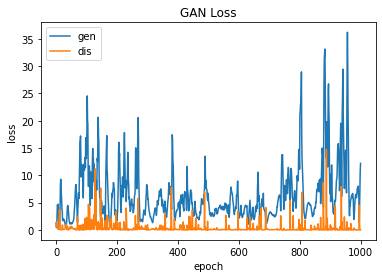

In [278]:
plt.plot(gen_loss)
plt.plot(dis_loss)
plt.title('GAN Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['gen', 'dis'], loc='upper left')
plt.show()

# generate some music

In [296]:
noise = np.random.rand(1, latent_dim)

In [297]:
gan_music = generator.predict(noise)

In [298]:
gan_music.shape

(1, 1, 90001)

In [299]:
ipd.Audio(gan_music[0][0],rate=3000)